/opt/homebrew/Caskroom/miniforge/base/envs/nn/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_23488/503990761.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via th

Average processing time per profile: 5.3960e+00 milliseconds
Feature thermal_net_flux: Mean Error = -0.01%, Median Error = -0.03%
Feature thermal_net_flux: Mean Absolute Error = 0.22%, Median Absolute Error = 0.15%
Feature reflected_net_flux: Mean Error = -0.15%, Median Error = 0.00%
Feature reflected_net_flux: Mean Absolute Error = 0.70%, Median Absolute Error = 0.46%


/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_23488/503990761.py:236: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0, 1].legend(loc="best", fontsize="small")
/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_23488/503990761.py:256: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 1].legend(loc="best", fontsize="small")


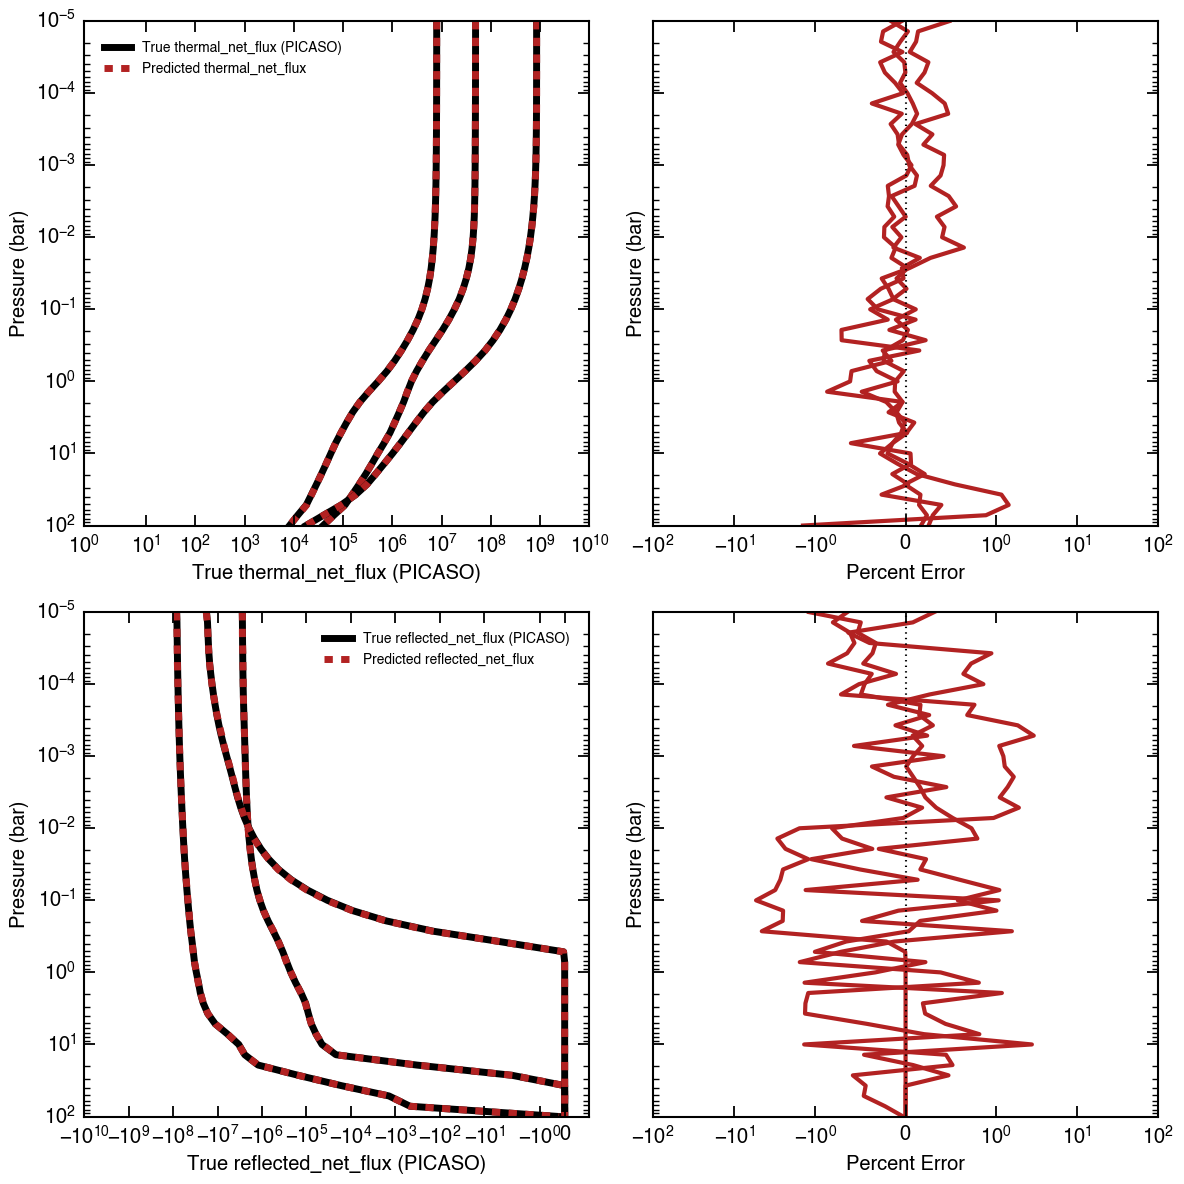

In [1]:
#!/usr/bin/env python3
"""
simple_plot.py - Minimal script to load the model and profiles using the previous
loading/denormalization code and then plot model predictions against true values
in a 4-panel plot. The top row shows the first target feature and the bottom row 
shows the second target feature. For each feature the left panel shows 
Predictions vs. True (solid black for true, dashed firebrick for predicted) and
the right panel shows the percent error. All axes are logarithmic.

Layout:
    Row 1 (Feature 1):
        Left: Predictions vs True (True = solid black, Predicted = dashed firebrick)
        Right: Percent Error (solid firebrick)
    Row 2 (Feature 2):
        Left: Predictions vs True (True = solid black, Predicted = dashed firebrick)
        Right: Percent Error (solid firebrick)
"""

import sys
sys.path.append('../src')

import json
import json5
from pathlib import Path
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from model import create_prediction_model
from normalizer import DataNormalizer
import time
import random

plt.style.use('science.mplstyle')

# Hard-coded paths
DATA_PATH = "../data/normalized_profiles"
METADATA_PATH = "../data/normalized_profiles/normalization_metadata.json"
MODEL_PATH = "../data/model/best_model.pt"  # adjust as needed
CONFIG_PATH = "../inputs/model_input_params.jsonc"

# --- Loading configuration, metadata, and model ---
with open(CONFIG_PATH, 'r') as f:
    config = json5.load(f)
with open(METADATA_PATH, 'r') as f:
    # Metadata is standard JSON so we can use json.load
    metadata = json.load(f)

# Create and load the model
model = create_prediction_model(config)
checkpoint = torch.load(MODEL_PATH, map_location='cpu')
model.load_state_dict(checkpoint['state_dict'], strict=False)
model.eval()

input_vars = config["input_variables"]
target_vars = config["target_variables"]  # e.g. ["thermal_net_flux", "reflected_net_flux"]
# We'll refer to the two target features as feature1 and feature2.
feature1, feature2 = target_vars[0], target_vars[1]
# Use "pressure" as the coordinate variable.
coord_var = "pressure"

# --- Function to process a profile ---
def process_profile(profile, config, coord_var):
    """
    Build the input dictionary from a profile using variable names from config.
    Returns the inputs dict, sequence length (based on coord_var), and coord values.
    """
    # Retrieve coordinate values (e.g., pressure) and determine sequence length.
    coord_vals = profile.get(coord_var, [])
    if not isinstance(coord_vals, list):
        coord_vals = [coord_vals]
    seq_len = len(coord_vals)
    
    inputs = {}
    # Use the first non-empty sequence type defined in config.
    for seq_type, var_list in config.get("sequence_types", {}).items():
        if var_list:
            seq_features = []
            for var_name in var_list:
                val = profile.get(var_name, 0)
                if isinstance(val, list):
                    # Pad with the last value if too short.
                    if len(val) < seq_len:
                        val = val + [val[-1]] * (seq_len - len(val))
                    else:
                        val = val[:seq_len]
                else:
                    val = [float(val)] * seq_len
                seq_features.append(torch.tensor(val, dtype=torch.float32))
            inputs[seq_type] = torch.stack(seq_features, dim=1).unsqueeze(0)
            break  # Use only the first valid sequence type.
    # Global features if defined.
    if config.get("global_variables"):
        global_values = []
        for var_name in config["global_variables"]:
            val = profile.get(var_name, 0)
            if isinstance(val, list):
                global_values.append(float(val[0]))
            else:
                global_values.append(float(val))
        inputs["global"] = torch.tensor(global_values, dtype=torch.float32).unsqueeze(0)
    return inputs, seq_len, coord_vals

# --- Select a few profiles for testing ---
all_files = [f for f in Path(DATA_PATH).glob("*.json") if f.name != "normalization_metadata.json"]
num_profiles = 3
if len(all_files) < num_profiles:
    selected_files = all_files
else:
    selected_files = random.sample(all_files, num_profiles)

# Prepare a 4-panel figure: 2 rows x 2 columns.
fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
profile_times = []

# Containers for error metrics for each feature.
errors_feature1 = []
errors_feature2 = []

# Define manual legend labels for easier modification.
legend_labels = {
    feature1: {"true": f"True {feature1} (PICASO)", "pred": f"Predicted {feature1}"},
    feature2: {"true": f"True {feature2} (PICASO)", "pred": f"Predicted {feature2}"}
}

# Set line widths for better visibility.
lw = 5

# Loop over selected profiles.
for file_path in selected_files:
    try:
        start_time = time.time()
        with open(file_path, 'r') as f:
            profile = json.load(f)
        # Process the profile using our function.
        inputs, seq_len, coord_vals = process_profile(profile, config, coord_var)
        
        with torch.no_grad():
            predictions = model(inputs)
            # Ensure predictions shape is [1, seq_len, num_targets].
            if predictions.dim() == 2:
                predictions = predictions.unsqueeze(1)
        
        proc_time = time.time() - start_time
        profile_times.append(proc_time)
        
        # Loop over the two target features.
        for j, feature in enumerate([feature1, feature2]):
            # Get true values from the profile.
            true_vals = profile.get(feature, [0] * seq_len)
            if not isinstance(true_vals, list):
                true_vals = [true_vals] * seq_len
            # Get corresponding predictions.
            target_idx = target_vars.index(feature)
            pred_vals = predictions[0, :seq_len, target_idx].cpu().numpy()
            
            # Denormalize true values, predictions, and coordinates.
            true_denorm = np.array(DataNormalizer.denormalize(true_vals, metadata, feature)).flatten()
            pred_denorm = np.array(DataNormalizer.denormalize(pred_vals, metadata, feature)).flatten()
            coord_denorm = np.array(DataNormalizer.denormalize(coord_vals, metadata, coord_var)).flatten()
            
            # Ensure lengths match.
            min_len = min(len(true_denorm), len(pred_denorm), len(coord_denorm))
            true_denorm = true_denorm[:min_len]
            pred_denorm = pred_denorm[:min_len]
            coord_denorm = coord_denorm[:min_len]
            
            # Compute percent error (avoid division by very small numbers).
            epsilon = 10
            error = 100 * (pred_denorm - true_denorm) / np.maximum(np.abs(true_denorm), epsilon)
            
            # Accumulate errors.
            if j == 0:
                errors_feature1.extend(error.tolist())
            else:
                errors_feature2.extend(error.tolist())
            
            # Select axes based on feature index.
            if j == 0:
                ax_pred = axs[0, 0]
                ax_err = axs[0, 1]
            else:
                ax_pred = axs[1, 0]
                ax_err = axs[1, 1]
            
            # Only add legend labels for the first profile.
            label_true = legend_labels[feature]["true"] if file_path == selected_files[0] else None
            label_pred = legend_labels[feature]["pred"] if file_path == selected_files[0] else None

            # Plot Predictions vs. True: X-axis = flux, Y-axis = pressure.
            ax_pred.plot(true_denorm, coord_denorm, color='black', linestyle='solid', linewidth=lw, label=label_true)
            ax_pred.plot(pred_denorm, coord_denorm, color='firebrick', linestyle='dashed', linewidth=lw, label=label_pred)
            
            # Plot Percent Error vs. Pressure.
            ax_err.plot(error, coord_denorm, color='firebrick', linestyle='solid', linewidth=3)
    
    except Exception as e:
        print(f"Error processing {file_path.name}: {e}")

# Compute and print average processing time.
if profile_times:
    avg_time = np.mean(profile_times)
    print(f"Average processing time per profile: {1000 * avg_time:.4e} milliseconds")

# Compute and print error metrics for each feature.
def print_error_metrics(errors, feat):
    if errors:
        mean_err = np.mean(errors)
        median_err = np.median(errors)
        mean_abs_err = np.mean(np.abs(errors))
        median_abs_err = np.median(np.abs(errors))
        print(f"Feature {feat}: Mean Error = {mean_err:.2f}%, Median Error = {median_err:.2f}%")
        print(f"Feature {feat}: Mean Absolute Error = {mean_abs_err:.2f}%, Median Absolute Error = {median_abs_err:.2f}%")

print_error_metrics(errors_feature1, feature1)
print_error_metrics(errors_feature2, feature2)

# --- Configure Panels with the same limits as before ---
# For Feature 1 (top row) Predictions vs. True panel.
axs[0, 0].set_xlim(1, 1e10)
axs[0, 0].set_ylim(1e2, 1e-5)
axs[0, 0].set_xlabel(f"{legend_labels[feature1]['true']}")
axs[0, 0].set_ylabel("Pressure (bar)")
axs[0, 0].set_xscale("symlog")
axs[0, 0].set_yscale("log")
axs[0, 0].legend(loc="best", fontsize="small")

# For Feature 1 Percent Error panel.
axs[0, 1].set_xlim(-100, 100)
axs[0, 1].set_ylim(1e2, 1e-5)
axs[0, 1].set_xlabel("Percent Error")
axs[0, 1].set_ylabel("Pressure (bar)")
axs[0, 1].set_xscale("symlog", linthresh=1)
axs[0, 1].set_yscale("log")
axs[0, 1].axvline(x=0, color="black", linestyle="dotted")
axs[0, 1].legend(loc="best", fontsize="small")


# For Feature 2 (bottom row) Predictions vs. True panel.
axs[1, 0].set_xlim(-1e10, 1)
axs[1, 0].set_ylim(1e2, 1e-5)
axs[1, 0].set_xlabel(f"{legend_labels[feature2]['true']}")
axs[1, 0].set_ylabel("Pressure (bar)")
axs[1, 0].set_xscale("symlog")
axs[1, 0].set_yscale("log")
axs[1, 0].legend(loc="best", fontsize="small")

# For Feature 2 Percent Error panel.
axs[1, 1].set_xlim(-100, 100)
axs[1, 1].set_ylim(1e2, 1e-5)
axs[1, 1].set_xlabel("Percent Error")
axs[1, 1].set_ylabel("Pressure (bar)")
axs[1, 1].set_xscale("symlog", linthresh=1)
axs[1, 1].set_yscale("log")
axs[1, 1].axvline(x=0, color="black", linestyle="dotted")
axs[1, 1].legend(loc="best", fontsize="small")

plt.tight_layout()
output_dir = Path("../plots")
output_dir.mkdir(exist_ok=True)
plt.savefig(output_dir / "simple_model_plot.png")
plt.show()


In [2]:
error

array([-1.19975467e+00, -4.96627693e-01, -5.31277377e-01, -3.29708235e-01,
       -3.66726608e-01, -4.69491256e-01, -1.05681454e-01, -5.16271656e-01,
       -7.16001139e-01,  7.63438762e-01,  6.83209973e-01,  1.86603374e+00,
        2.93505202e+00,  1.10324178e+00,  1.24018671e+00,  1.29005202e+00,
        1.66606140e+00,  1.39901681e+00,  1.11801075e+00,  1.92397778e+00,
        9.75250454e-01, -1.56841962e+00, -2.93695726e+00, -2.33249588e+00,
       -1.22218741e+00, -2.50095065e+00, -2.70214420e+00, -3.12293597e+00,
       -5.37474740e+00, -2.49690688e+00, -2.52458870e+00, -4.56912681e+00,
       -2.12316513e-01, -3.89881432e-03, -5.32658305e-06, -2.30050556e-08,
        5.22519628e-09, -7.56038232e-09,  8.28114521e-09,  2.38912445e-08,
        1.85595961e-08,  7.18290705e-09, -5.14597642e-09,  2.13092255e-08,
        2.30324995e-09,  1.70931758e-08, -4.15188078e-09,  3.53652374e-08,
        1.07046683e-08,  2.99019232e-08])